# Quantised Random Embeddings and the Quantized Eclipse Problem

This notebook illustrates some aspects of the dimensionality reduction addressed in [1],[2],[3] when applied to practical supervised learning problems, and as compared to the simplest case of adaptive dimensionality reduction, *i.e.*, principal component analysis (PCA).

[1] Valerio Cambareri, Chunlei Xu, and Laurent Jacques.  <a href="https://arxiv.org/abs/1702.04664">"The Rare Eclipse Problem on Tiles: Quantised Embeddings of Disjoint Convex Sets."</a> arXiv preprint arXiv:1702.04664 (2017). Submitted to 12th International Conference on Sampling Theory and Applications (SampTA 2017), July 3 – 7, 2017, Tallinn, Estonia (an earlier version of this work will be presented at SPARS'17 in Lisbon, June 5th-8th 2017).

[2]  Laurent Jacques and Valerio Cambareri. <a href="https://arxiv.org/abs/1607.00816">"Time for dithering: fast and quantized random embeddings via the restricted isometry property."</a> arXiv preprint arXiv:1607.00816 (2016). In  Information and Inference: A Journal of the IMA, accepted and in press, Mar. 2017.

[3] Laurent Jacques. <a href="https://arxiv.org/abs/1504.06170">"Small Width, Low Distortions: Quantized Random Embeddings of Low-complexity Sets."</a> arXiv preprint arXiv:1504.06170 (2015). IEEE Trans. Inf. Theory, in peer review, Mar. 2017.

In [1]:
# Let's first import the required libraries.
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
from cvxpy import *
from itertools import combinations
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits, make_blobs

## Quantised Random Projections and Quasi-Isometric Embeddings
Non-linear dimensionality reduction techniques are important components in machine learning frameworks for very large-scale datasets. Among such techniques, we focus on *quantised random embeddings*. 
First off, let us introduce their definition when using quantised Gaussian random projections (in the following, they are addressed as QRPs), *i.e.*, as obtained by a non-linear map $\mathsf{A}$ applied to $\boldsymbol x \in \mathcal K \subset \mathbb R^n$ (with $\mathcal K$ the *dataset*), that is
$$
\boldsymbol y = {\mathsf A} (\boldsymbol x) := {\mathcal Q}_{\delta}(\boldsymbol \Phi \boldsymbol x + \boldsymbol \xi)
$$
with $\boldsymbol \Phi \in \mathbb R^{m\times n}$ a random *sensing matrix*, ${\mathcal Q}_{\delta} (\cdot) := \delta \lfloor \frac{\cdot}{\delta} \rfloor$ a *uniform scalar quantiser* of *resolution* $\delta>0$ (applied component-wise), and the *signature* $\boldsymbol y \in \delta \mathbb Z^m$. The *dithering* $\boldsymbol\xi \sim {\mathcal U}^{m}([0,{\delta}])$ is a well-known means to stabilise the action of the quantiser. One-bit random embeddings are a particular case of this arrangement, when $\delta$ is sufficiently large before the range of the components of $\boldsymbol x \in \mathcal K$. 

The non-linear map $\mathsf A$ is a non-adaptive dimensionality reduction that yields compact signatures for storage and transmission, while retaining a notion of *quasi-isometry* [3] (distance preservation, *e.g.*, as an approximate isometry between $(\mathbb R^n, \ell_2)$ and $(\delta \mathbb Z^m, \ell_1)$ up to some bounded, controlled additive and multiplicative distortions of the distances) that enables the approximation of $\boldsymbol x$. 

The code defining such an embedding is very simple and given below. As shown in the findings of [2] $\boldsymbol\Phi$ could also be constructed as a fast transform, and would still have *quasi-isometric* behaviour between $(\mathbb R^n, \ell_2)$ and $(\delta \mathbb Z^m, \ell_2)$, albeit with a worse distortion of the distances. 
However, [2] provides also a "bi-dithered" variant of the mapping $\mathsf A$ (combining two dither vectors per row of $\boldsymbol\Phi$), not covered here, which still has low distortion)

An example of fast transform is a subsampled random convolution operator $\boldsymbol\Phi = \boldsymbol I_\Omega \boldsymbol F^*_n  \text{diag}(\boldsymbol F_n \boldsymbol h)\boldsymbol F_n$, with $\Omega \subset [n]: |\Omega| = m$. Hence, the code below implements "randn" (as the former description, with Gaussian random projections) or "randc" (as the latter description, with a random Gaussian convolution kernel).

Note that this view on QRPs is quite connected to Locality Sensitive Hashing (and the results Piotr Indyk *et al.*).

In [2]:
def quant_rand_embed(x, m=2, delta=1, rngseed=42, mode="randn"):
    ''' 
    Quantised Random Embedding using Random Projections
    and Uniform Scalar Quantisation with Dithering
    
    See also:
    Laurent Jacques and Valerio Cambareri. 
    "Time for dithering: fast and quantized random embeddings via the restricted isometry property." 
    arXiv preprint arXiv:1607.00816 (2016). 
    In Information and Inference: A Journal of the IMA, accepted and in press, Mar. 2017.
    
    Inputs:
    x         input data             ndarray, shape (nvariables, nsamples)
    m         output feature size    int
    delta     quantiser bin width    float (>0)
    rngseed   generator state        int
    mode      type of random proj.   string
    
    Outputs:
    w         output features        float (quantised)
    q         output features        np.int16 (quantised)
    '''
    
    # Initialise the quant. rand. proj. setup 
    dims = np.shape(x)
    np.random.seed(rngseed)
    if delta <= 0:
        raise Exception('Quantiser resolution parameter must be positive!')

    # Apply the sensing operator
    # The random projection is applied to axis 0 of the input data, which is  
    # assumed as a matrix of size $n \times p$
    if mode=="randn":
        # Gaussian Random Projections
        phi = np.random.standard_normal([m,dims[0]])
        q = np.dot(phi, x)
        
    elif mode=="randc":
        # Random Convolution using Antipodal Kernel (via FFT)
        ker = 2*(np.random.randint(0,1,dims[0])-0.5)
        idx = np.random.choice(dims[0],size=m,replace=False)
        q = np.fft.irfft(np.dot(np.diag(np.fft.rfft(ker)),np.fft.rfft(x,axis=0)),axis=0)[idx]
        # # Alternative w. convolve
        # q = (np.apply_along_axis(lambda x: np.convolve(x,ker,mode='fft'), 0, x))[idx]

    else:
        raise Exception('Mode not recognised. Only "randn" and "randc" are implemented so far.')
    
    # Generate dithering
    xi = np.random.uniform(-delta*0.5,delta*0.5,m)

    # Apply dithering and quantise with round operation
    w = np.round((q + (np.tile(xi,[dims[1],1])).T)/delta)
    return w*delta, np.int16(w)

## Dataset Generation and Analysis
For the scope of this analysis, let us consider a labelled dataset $\mathcal K := \cup^C_{j=1} \mathcal C_j$, where the class $\mathcal C_j$ is identified by a label $j$ and comprised of the datapoints $\{\boldsymbol x_i \in \mathcal C_j\}$ (note: in the theoretical analysis of [1] the classes are not necessarily finite). Our purpose will be to model the dataset as disjoint convex sets (*e.g.*, convex hulls, or minimum volume spheres enclosing each class), and to understand how QRP interact with these sets - how the quantiser resolution $\delta$ should be chosen, how $m$ should scale with the complexity of the underlying set. As this is only a demo, a thorough explanation of these concepts can be found in [1],[2].

In [3]:
# Prepare train/test data  
nclass = 5 # Number of classes, $C$
rseed = 42 # Seed of random number generator
dset = "real" # Digits dataset (real data)
# dset = "" # Blobs dataset (randomly generated)

if dset == "real":
    # The Digits dataset (real)
    # This is the well-known handwritten digits dataset, loaded with nclass labels.
    # The classes will tend to be closer and overlap, thus departing from our 
    # theoretical analysis that assumes linear separability. 
    n = 64
    digits = load_digits(nclass)
    nsamples = digits.data.shape[0]
    idx_train = np.random.choice(nsamples, nsamples//2, replace=False)
    idx_test = np.setxor1d(np.arange(nsamples),idx_train)
    train_data = digits.data[idx_train]
    test_data = digits.data[idx_test]
    ctrain = digits.target[idx_train]
    ctest = digits.target[idx_test]
else:
    # The Blob dataset (synthetic)
    # This is a randomly generated dataset of blobs that tend to be sufficiently far apart.
    # The classes will tend to be separated, thus verifying our theoretical analysis. 
    n = 2**9
    nsamples = 2**7
    data,target = make_blobs(n_samples=nsamples, 
                             n_features=n, centers=nclass, 
                             cluster_std=0.5)
    idx_train = np.random.choice(nsamples, 2*nsamples//3, replace=False)
    idx_test = np.setxor1d(np.arange(nsamples),idx_train)
    train_data = data[idx_train]
    test_data = data[idx_test]
    ctrain = target[idx_train]
    ctest = target[idx_test]

We now extract some general information on the geometry of the labelled dataset by finding its equivalent $\ell_2$-ball partition, we now find the centre of each point cloud $\boldsymbol c_j = \sum_{i\in\mathcal C_j} \boldsymbol x_i$ and fit a ball with radius given by $r_j = \max_i \|\boldsymbol x_i -\boldsymbol c_j\|$, for $j \in [C]$.

In [4]:
# Fit $\ell_2$-balls to each dataset
centre = np.zeros([n,nclass])
radius = np.zeros(nclass)
for i in range(nclass):
    centre[i,] = np.mean(train_data[ctrain == i])
    nclassi = sum(ctrain == i)
    radius[i] = np.max(np.linalg.norm(train_data[ctrain == i]-np.tile(centre[:,i],(nclassi,1)),axis=1))
    
print("The ball classes' radii are " + str(radius))

The ball classes' radii are [ 72.84556808  77.21269502  68.91675798  67.85651666  68.13583423]


We can also obtain the intra-class distance $\sigma_{j,j'} = \min_{i,i'} \|\boldsymbol x_i - \boldsymbol x_{i'}\|: \boldsymbol x_i \in \mathcal C_j, \boldsymbol x_{i'} \in \mathcal C_{j'}, j \neq j'$, and actually let $\sigma := \min \sigma_{j,j'}$. If this is relatively small, it will be harder to preserve the separability of each class after projection. 

In [5]:
# Minimum intra-class distance (closest point problem)
mind = np.inf*np.ones([nclass,nclass])
for i in range(nclass):
    for j in range(i+1,nclass):
        dists = pairwise_distances(train_data[ctrain == i], train_data[ctrain == j], metric='euclidean')
        mind[i,j] = np.min(dists)
        
sigma = np.min(mind)
print("The separation between classes is " + str(sigma))

The separation between classes is 22.6053091109


As a final assessment on the dataset, we pick $m = n/4$ (25% of the number of features) and simulate with a typical instance of QRP what is the smallest margin $$\tau := \min_{j,j'} \{\min_{\boldsymbol z \in \mathbb{R}^n} \|\boldsymbol\Phi \boldsymbol z \|_\infty: \boldsymbol z \in \mathcal C_- := \mathcal C_j - \mathcal C_{j'}\}, \ \tau > 0.$$ The rationale is simple: any vector $\boldsymbol z \in \mathbb R^n$ so that $\|\boldsymbol\Phi \boldsymbol z \|_\infty < \delta$ for some $\delta > 0$ is surely consistent, *i.e.*, so if $\boldsymbol z = \boldsymbol x - \boldsymbol x'$ verifies this condition $\boldsymbol x$ and $\boldsymbol x'$ will be mapped to the same quantiser cell, and hence they will not be distinguishable when belonging to different classes. For this reason, we take $\boldsymbol z \in \mathcal C_-$ in the appropriate difference set. Taking the smallest of such $\tau$ among all classes returns the smallest $\ell_\infty$-sense margin between classes in the projected domain.

In [6]:
# Test the $\ell_\infty margin$ between classes in projected domain 
combis = combinations(range(nclass),2)
coms = np.asarray([p for p in combis])
tau = np.zeros(len(coms),dtype=float)
m = n//4
    
np.random.seed(rseed)
Phi = np.random.standard_normal([m,n])

for i in range(len(coms)):
    c = np.subtract(centre[:,coms[i,0]],centre[:,coms[i,1]])
    z = Variable(n)
    obj = Minimize(norm(Phi*z, "inf"))
    con = [norm(z-c) <= radius[coms[i,0]]+coms[i,1]]
    prob = Problem(obj,  con)
            
    try:
        prob.solve(solver=ECOS,verbose=False) 
    except SolverError:
        prob.solve(solver=SCS,verbose=False)
        
    tau_star = obj.value        
    tau[i] = tau_star         
       
print("The current tau are: %s" % str(tau))

The current tau are: [  7.17963113e-15   2.76490794e-14   7.48169772e-15   4.78951887e-15
   2.93779955e-14   5.77524159e-15   6.20204167e-15   9.75360505e-15
   4.97925791e-15   1.07800317e-14]


Ideally, choosing any $0<\delta \leq \tau$ when $\tau > 0$ will avoid that two datapoints belonging to different classes fall in the same quantiser cell after projection. If $\tau = 0$, then it is clear that the $\text{Null}(\boldsymbol \Phi)$ intersects at least one $\mathcal C_-$, and that will cause at least two points in the datasets above to overlap. 

However, this is an excessively strict approach for two reasons: firstly, the dither $\boldsymbol\xi$ introduces a shift in the tiling of the projected domain so that, even if $0 < \delta \leq \tau$, there are cases cases in which the classes could be separable by virtue of dithering; hence, the probability that the classes "eclipse", *i.e.*, $$P_f := \mathbb P[\exists \boldsymbol x \in \mathcal C_j, \boldsymbol x' \in \mathcal C_{j'} : \mathsf{A}(\boldsymbol x) = \mathsf{A}(\boldsymbol x')]$$ is actually smaller in the presence of dithering. Secondly, the empirical probability of error $P_e$ of a *classifier* on a dataset will be typically $P_e \ll P_f$, as the latter really is a worst-case analysis considering the most critical pair of points between two potentially continuous classes $\mathcal C_j, \mathcal C_{j'}$.

Clearly, this outline of the analysis in [1] is only meant to address separable classes. In natural datasets, it is almost often the case that an overlap between the classes will exist. This explains why, when considering the "real" and low-dimensional dataset above (handwritten digits) $\tau$ is almost $0$ (up to machine precision, as output by the optimisation problem).

Nevertheless, analysing the above margin can be seen as a way to probe how a quasi-isometric, distance-preserving embedding such as $\mathsf{A}$ alters disjoint and easily classified, but high-dimensional datasets. 

## An "Unfair" Comparison between Quantised Random Projections (${\rm QRP}_{m,\delta}$) and Principal Components Analysis (${\rm PCA}_m$)

In order to compare the signatures produced by QRP (a *non-adaptive* technique, involving no training and merely leveraging consequences of the Johnson-Lindenstrauss Lemma) with those output by a PCA of the same dimension (an *adaptive* technique, involving training), we now:

1. Apply $\mathsf A$ at a given quantiser resolution $\delta$.

2. At the same amount of measurements $m$, fit PCA on the training set and apply it on the test set.

3. Run on both signature sets 5-Nearest Neighbours Classification, calling it once for each training set (*i.e.*, the signatures corresponding to the training set), and predicting the labels on the respective test sets.

4. Evaluate the probability of error of 5-NN under QRP and PCA.

This procedure can be tested by varying the number of measurements $m$ on the training and test sets, as in the cell below.

In [7]:
# With respect to $m$
M = np.unique(np.ceil(n*2**np.arange(-np.log2(n),-1,1))).astype(int)
msteps = len(M)
# delta = min(tau) # Safe estimate
delta = sigma # Rough estimate (relies on isometry)

qrp_perr = []
pca_perr = []

for ss in range(msteps):
    # Apply QRP with dimension m and resolution delta
    print("QRP_" + str(M[ss]))
    %time red_train,_ = quant_rand_embed(train_data.T,m=M[ss],delta=delta,rngseed=rseed)
    red_test,_ = quant_rand_embed(test_data.T,m=M[ss],delta=delta,rngseed=rseed)
    red_train = red_train.T
    red_test = red_test.T
    
    # Apply PCA with the same dimension m, and train it
    print("PCA_" + str(M[ss]))
    PC = PCA(n_components=M[ss])
    %time PC.fit(train_data)
    pca_train = PC.transform(train_data)
    pca_test = PC.transform(test_data)
    
    # Run k-NN on reduced-dim. dataset
    KNN = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
    KNN.fit(red_train,ctrain)
    qrp_cpred = KNN.predict(red_test)
    qrp_perr.append(float(sum(qrp_cpred != ctest))/ctest.size)
    KNN.fit(pca_train,ctrain)
    pca_cpred = KNN.predict(pca_test)
    pca_perr.append(float(sum(pca_cpred != ctest))/ctest.size)
    bitrate = np.floor(np.log2((np.unique(red_train[:])).size))+1

QRP_1
CPU times: user 6.21 ms, sys: 979 µs, total: 7.19 ms
Wall time: 2.32 ms
PCA_1
CPU times: user 52.7 ms, sys: 8.22 ms, total: 60.9 ms
Wall time: 21.8 ms
QRP_2
CPU times: user 1.18 ms, sys: 201 µs, total: 1.38 ms
Wall time: 367 µs
PCA_2
CPU times: user 8.83 ms, sys: 571 µs, total: 9.41 ms
Wall time: 2.41 ms
QRP_4
CPU times: user 1.24 ms, sys: 130 µs, total: 1.37 ms
Wall time: 323 µs
PCA_4
CPU times: user 9.56 ms, sys: 253 µs, total: 9.82 ms
Wall time: 2.46 ms
QRP_8
CPU times: user 1.22 ms, sys: 101 µs, total: 1.32 ms
Wall time: 315 µs
PCA_8
CPU times: user 7.32 ms, sys: 138 µs, total: 7.46 ms
Wall time: 1.86 ms
QRP_16
CPU times: user 1.28 ms, sys: 105 µs, total: 1.38 ms
Wall time: 336 µs
PCA_16
CPU times: user 7.47 ms, sys: 451 µs, total: 7.92 ms
Wall time: 2.02 ms


As shown from the output above, a call to QRP is $\approx 8$ to $10$ times faster than scikit-learn's PCA fitting to the $m$ principal components estimated from the data alone. Clearly, this will come at a loss in terms of probability of error, but the perk of using QRP with a sufficiently small $\delta$ will be two-fold. On one hand, it will allow for storage of the signatures in a few bits; on the other hand, the computation can be achieved in $O(m n)$ with $m$-dim. signatures and $n$-dim. features, or simply $O(n \log n)$ when using random convolution to define $\boldsymbol\Phi$ as it involves a fast transform. 

A plot of the probability of error $P_e$ measured after 5-NN classification closes this section, and allows us to see that, as $m/n$ increases, $P_e (\rm QRP)$ approaches $P_e (\rm PCA)$ (the latter naturally overfits the dataset for large $m$).

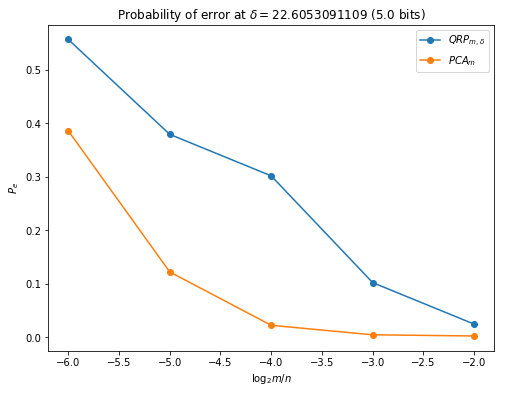

In [8]:
# Plot results (M)
plt.figure(figsize=(8,6))
plt.plot(np.log2(M/n),qrp_perr,label="$QRP_{m,\delta}$", marker='o')
plt.plot(np.log2(M/n),pca_perr,label="$PCA_{m}$", marker='o')
plt.title("Probability of error at $\delta = " + str(delta) + "$ (" + str(bitrate) + " bits)")
plt.xlabel("$\\log_2 m/n$")
plt.ylabel("$P_e$")
plt.legend()
plt.show()

We can now similarly assess the effect of $\delta$ on the same $P_e$, which we vary in a range obtained from the previous simulation.

In [9]:
# With respect to $\delta$
D = 2.0**np.arange(-12,12,1)
dsteps = len(D)
m = min(M[np.asarray(qrp_perr) <=0.1])

bitrates = []
qrp_perr_bit = []

for dd in range(dsteps):
    # Apply QRP with dimension m and resolution delta
    red_train,_ = quant_rand_embed(train_data.T,m,delta=D[dd],rngseed=rseed,mode="randn")
    red_test,_ = quant_rand_embed(test_data.T,m,delta=D[dd],rngseed=rseed,mode="randn")
    red_train = red_train.T
    red_test = red_test.T
    
    # Run k-NN on reduced-dim. dataset
    KNN = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
    KNN.fit(red_train,ctrain)
    qrp_cpred = KNN.predict(red_test)
    qrp_perr_bit.append(float(sum(qrp_cpred != ctest))/ctest.size)
    bitrates.append(np.floor(np.log2((np.unique(red_train[:])).size))+1)

The error probability of 5-NN is reported below, illustrating how for large $\delta$ the accuracy rapidly degrades.

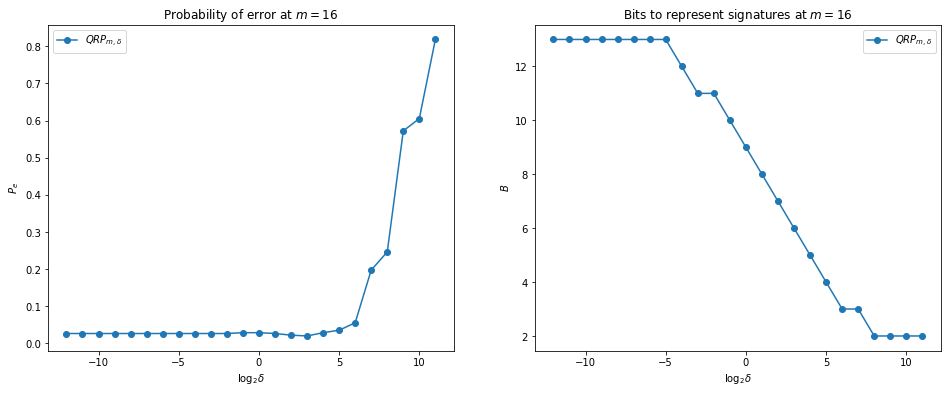

In [10]:
# Plot results (\delta)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(np.log2(D),qrp_perr_bit,label="$QRP_{m,\delta}$",marker='o')
plt.title("Probability of error at $m = " + str(m) + "$")
plt.xlabel("$\\log_2 \delta$")
plt.ylabel("$P_e$")
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.log2(D),bitrates,label="$QRP_{m,\delta}$",marker='o')
plt.title("Bits to represent signatures at $m = " + str(m) + "$")
plt.xlabel("$\\log_2 \delta$")
plt.ylabel("$B$")
plt.legend()
plt.show()